In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# -*- coding: UTF-8 -*-

import pandas as pd
import numpy as np

downloaded = drive.CreateFile({'id':'1HZuB72isbfMsD8Geete4jE3BGYjq_crh'}) 
downloaded.GetContentFile('train_format1.csv')  
train_df = pd.read_csv('train_format1.csv', dtype=str)
# train_df = pd.read_csv('/Users/hanmufu/Workspaces/Repeat_Buyers_Prediction/data_format1/train_format1.csv', dtype=str)
print("train_format1 loaded successful")
print(train_df.head())

downloaded = drive.CreateFile({'id':'150ckojM6uQWLq0AJYxPR4IKHJcFiJDKG'}) 
downloaded.GetContentFile('user_log_format1.csv')  
user_log_df = pd.read_csv('user_log_format1.csv', dtype=str)
# user_log_df = pd.read_csv('/Users/hanmufu/Workspaces/Repeat_Buyers_Prediction/data_format1/user_log_format1.csv', dtype=str)
print("user_log_format1 loaded successful")
print(user_log_df.head())

downloaded = drive.CreateFile({'id':'1S3J8iOFgHiHlcwymw5WChH5KiAyPlfGK'}) 
downloaded.GetContentFile('user_info_format1.csv')  
user_info_df = pd.read_csv('user_info_format1.csv', dtype=str)
# user_info_df = pd.read_csv('/Users/hanmufu/Workspaces/Repeat_Buyers_Prediction/data_format1/user_info_format1.csv', dtype=str)
print("user_info_format1 loaded successful")
print(user_info_df.head())

downloaded = drive.CreateFile({'id':'1VwctgbmJScM1fBS22Nk5N8PiwMmNlwOX'}) 
downloaded.GetContentFile('test_format1.csv')  
test_df = pd.read_csv('test_format1.csv', dtype=str)
# test_df = pd.read_csv('/Users/hanmufu/Workspaces/Repeat_Buyers_Prediction/data_format1/test_format1.csv', dtype=str)
print("test_df loaded successful")
print(test_df.head())

train_format1 loaded successful
  user_id merchant_id label
0   34176        3906     0
1   34176         121     0
2   34176        4356     1
3   34176        2217     0
4  230784        4818     0
user_log_format1 loaded successful
  user_id  item_id cat_id seller_id brand_id time_stamp action_type
0  328862   323294    833      2882     2661       0829           0
1  328862   844400   1271      2882     2661       0829           0
2  328862   575153   1271      2882     2661       0829           0
3  328862   996875   1271      2882     2661       0829           0
4  328862  1086186   1271      1253     1049       0829           0
user_info_format1 loaded successful
  user_id age_range gender
0  376517         6      1
1  234512         5      0
2  344532         5      0
3  186135         5      0
4   30230         5      0
test_df loaded successful
  user_id merchant_id prob
0  163968        4605  NaN
1  360576        1581  NaN
2   98688        1964  NaN
3   98688        3645  Na

In [0]:
# seperate month from time_stamp
user_log_df['month'] = user_log_df['time_stamp'].str[:2]

In [0]:
user_log_df = user_log_df.rename(columns={'seller_id': 'merchant_id'})

In [0]:
# data cleaning
values = {'brand_id': 0}
user_log_df.fillna(value=values, inplace=True)
values = {'age_range': 0, 'gender': 2}
user_info_df.fillna(value=values, inplace=True)

In [0]:
# join users' age and gender into train_df
train_df = pd.merge(train_df, user_info_df, on=['user_id'], how='left')
test_df = pd.merge(test_df, user_info_df, on=['user_id'], how='left')

In [0]:
# Feature Engineering
# Deviation of user's purchase between Nov and before
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "2"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "2"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['mean_of_num_of_actions_not_in_nov'] = user_actions_not_at_nov.mean(axis=1)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res['user_buy_deviation_between_nov_and_before'] = abs(res['cnt'] - res['mean_of_num_of_actions_not_in_nov'])
res = res.loc[:, ['user_id', 'merchant_id', 'user_buy_deviation_between_nov_and_before']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')
# Deviation of user's click between Nov and before
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "0"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "0"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['mean_of_num_of_actions_not_in_nov'] = user_actions_not_at_nov.mean(axis=1)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res['user_click_deviation_between_nov_and_before'] = abs(res['cnt'] - res['mean_of_num_of_actions_not_in_nov'])
res = res.loc[:, ['user_id', 'merchant_id', 'user_click_deviation_between_nov_and_before']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')
# Deviation of user's cart between Nov and before
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "1"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "1"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['mean_of_num_of_actions_not_in_nov'] = user_actions_not_at_nov.mean(axis=1)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res['user_cart_deviation_between_nov_and_before'] = abs(res['cnt'] - res['mean_of_num_of_actions_not_in_nov'])
res = res.loc[:, ['user_id', 'merchant_id', 'user_cart_deviation_between_nov_and_before']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')
# Deviation of user's favorite between Nov and before
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "3"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "3"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['mean_of_num_of_actions_not_in_nov'] = user_actions_not_at_nov.mean(axis=1)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res['user_favorite_deviation_between_nov_and_before'] = abs(res['cnt'] - res['mean_of_num_of_actions_not_in_nov'])
res = res.loc[:, ['user_id', 'merchant_id', 'user_favorite_deviation_between_nov_and_before']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')

In [0]:
# Number of user purchase with this merchant before Nov
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['action_type'] == "2"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id'], as_index=False)['action_type'].agg({'num_of_buy_before_nov':'count'})
train_df = pd.merge(train_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
# Number of user click with this merchant before Nov
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['action_type'] == "0"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id'], as_index=False)['action_type'].agg({'num_of_click_before_nov':'count'})
train_df = pd.merge(train_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
# Number of user cart with this merchant before Nov
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['action_type'] == "1"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id'], as_index=False)['action_type'].agg({'num_of_cart_before_nov':'count'})
train_df = pd.merge(train_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
# Number of user favorite with this merchant before Nov
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['action_type'] == "3"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id'], as_index=False)['action_type'].agg({'num_of_favorite_before_nov':'count'})
train_df = pd.merge(train_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, user_actions_not_at_nov, on=['user_id', 'merchant_id'], how='left')

In [0]:
# mean and standard deviation of num of purchase per month between user and merchant (may - nov)
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "2"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "2"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res_for_mean_and_deviation = res.loc[:, ['cnt', '05', '06', '07', '08', '09', '10']]
res['mean_for_buy_num_from_may_to_nov'] = res_for_mean_and_deviation.mean(axis=1)
res['std_for_buy_num_from_may_to_nov'] = res_for_mean_and_deviation.std(axis=1)
res = res.loc[:, ['user_id', 'merchant_id', 'mean_for_buy_num_from_may_to_nov', 'std_for_buy_num_from_may_to_nov']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')
# mean and standard deviation of num of clicks per month between user and merchant (may - nov)
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "0"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "0"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res_for_mean_and_deviation = res.loc[:, ['cnt', '05', '06', '07', '08', '09', '10']]
res['mean_for_click_num_from_may_to_nov'] = res_for_mean_and_deviation.mean(axis=1)
res['std_for_click_num_from_may_to_nov'] = res_for_mean_and_deviation.std(axis=1)
res = res.loc[:, ['user_id', 'merchant_id', 'mean_for_click_num_from_may_to_nov', 'std_for_click_num_from_may_to_nov']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')
# mean and standard deviation of num of add-to-cart per month between user and merchant (may - nov)
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "1"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "1"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res_for_mean_and_deviation = res.loc[:, ['cnt', '05', '06', '07', '08', '09', '10']]
res['mean_for_cart_num_from_may_to_nov'] = res_for_mean_and_deviation.mean(axis=1)
res['std_for_cart_num_from_may_to_nov'] = res_for_mean_and_deviation.std(axis=1)
res = res.loc[:, ['user_id', 'merchant_id', 'mean_for_cart_num_from_may_to_nov', 'std_for_cart_num_from_may_to_nov']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')
# mean and standard deviation of num of add-to-favorite per month between user and merchant (may - nov)
user_actions_at_nov = user_log_df.loc[user_log_df['month'] == "11"]
user_actions_at_nov = user_actions_at_nov.loc[user_actions_at_nov['action_type'] == "3"]
user_actions_not_at_nov = user_log_df.loc[user_log_df['month'] != "11"]
user_actions_not_at_nov = user_actions_not_at_nov.loc[user_actions_not_at_nov['action_type'] == "3"]
user_actions_not_at_nov = user_actions_not_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov['user_id'] + '/' + user_actions_not_at_nov['merchant_id']
user_actions_not_at_nov = user_actions_not_at_nov.pivot(index='user_id/merchant_id', columns='month', values='cnt')
user_actions_not_at_nov = user_actions_not_at_nov.fillna(0)
user_actions_not_at_nov['user_id/merchant_id'] = user_actions_not_at_nov.index
user_actions_not_at_nov['user_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[0]
user_actions_not_at_nov['merchant_id'] = user_actions_not_at_nov['user_id/merchant_id'].str.split('/').str[1]
user_actions_at_nov = user_actions_at_nov.groupby(['user_id', 'merchant_id', 'month'], as_index=False)['month'].agg({'cnt':'count'})
res = pd.merge(user_actions_at_nov, user_actions_not_at_nov, on=['user_id', 'merchant_id'])
res_for_mean_and_deviation = res.loc[:, ['cnt', '05', '06', '07', '08', '09', '10']]
res['mean_for_favorite_num_from_may_to_nov'] = res_for_mean_and_deviation.mean(axis=1)
res['std_for_favorite_num_from_may_to_nov'] = res_for_mean_and_deviation.std(axis=1)
res = res.loc[:, ['user_id', 'merchant_id', 'mean_for_favorite_num_from_may_to_nov', 'std_for_favorite_num_from_may_to_nov']]
train_df = pd.merge(train_df, res, on=['user_id', 'merchant_id'], how='left')
test_df = pd.merge(test_df, res, on=['user_id', 'merchant_id'], how='left')

In [0]:
# number of days the merchant sells an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "2"]
purchase_action = purchase_action.groupby(['merchant_id'], as_index=False)['action_type'].agg({'merchant_sales':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# number of days the merchant click an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "0"]
purchase_action = purchase_action.groupby(['merchant_id'], as_index=False)['action_type'].agg({'merchant_click':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# number of days the merchant add-to-cart an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "1"]
purchase_action = purchase_action.groupby(['merchant_id'], as_index=False)['action_type'].agg({'merchant_add_to_cart':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# number of days the merchant add-to-favorite an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "3"]
purchase_action = purchase_action.groupby(['merchant_id'], as_index=False)['action_type'].agg({'merchant_add_to_favorite':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# ratio of actions/purchase
train_df['mrate_click'] = train_df['merchant_click'] / train_df['merchant_sales']
test_df['mrate_click'] = test_df['merchant_click'] / test_df['merchant_sales']
train_df['mrate_cart'] = train_df['merchant_add_to_cart'] / train_df['merchant_sales']
test_df['mrate_cart'] = test_df['merchant_add_to_cart'] / test_df['merchant_sales']
train_df['mrate_favorite'] = train_df['merchant_add_to_favorite'] / train_df['merchant_sales']
test_df['mrate_favorite'] = test_df['merchant_add_to_favorite'] / test_df['merchant_sales']

In [0]:
# number of times the buyer buy an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "2"]
purchase_action = purchase_action.groupby(['user_id'], as_index=False)['action_type'].agg({'user_buy':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# number of times the buyer click an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "0"]
purchase_action = purchase_action.groupby(['user_id'], as_index=False)['action_type'].agg({'user_click':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# number of times the buyer add-to-cart an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "1"]
purchase_action = purchase_action.groupby(['user_id'], as_index=False)['action_type'].agg({'user_add_to_cart':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# number of times the buyer add-to-favorite an item
purchase_action = user_log_df.loc[user_log_df['action_type'] == "3"]
purchase_action = purchase_action.groupby(['user_id'], as_index=False)['action_type'].agg({'user_add_to_favorite':'count'})
train_df = pd.merge(train_df, purchase_action, how='left')
test_df = pd.merge(test_df, purchase_action, how='left')
# ratio of actions/purchase
train_df['urate_click'] = train_df['user_click'] / train_df['user_buy']
test_df['urate_click'] = test_df['user_click'] / test_df['user_buy']
train_df['urate_cart'] = train_df['user_add_to_cart'] / train_df['user_buy']
test_df['urate_cart'] = test_df['user_add_to_cart'] / test_df['user_buy']
train_df['urate_favorite'] = train_df['user_add_to_favorite'] / train_df['user_buy']
test_df['urate_favorite'] = test_df['user_add_to_favorite'] / test_df['user_buy']

In [0]:
# number of unique items clicked by the different sexual users in the merchant
user_log_with_gender = pd.merge(user_log_df, user_info_df, on='user_id', how='left')
num_of_items_clicked = user_log_with_gender.loc[user_log_with_gender['action_type'] == "0"]
num_of_items_clicked = num_of_items_clicked.groupby(['merchant_id', 'item_id', 'gender'], as_index=False)['action_type'].agg({'cnt':'count'})
num_of_items_clicked = num_of_items_clicked.groupby(['merchant_id', 'gender'], as_index=False)['item_id'].agg({'num_of_items_clicked_by_gender':'count'})
train_df = pd.merge(train_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
test_df = pd.merge(test_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])

In [0]:
# number of unique categories clicked by the different sexual users in the merchant
num_of_items_clicked = user_log_with_gender.loc[user_log_with_gender['action_type'] == "0"]
num_of_items_clicked = num_of_items_clicked.groupby(['merchant_id', 'cat_id', 'gender'], as_index=False)['action_type'].agg({'cnt':'count'})
num_of_items_clicked = num_of_items_clicked.groupby(['merchant_id', 'gender'], as_index=False)['cat_id'].agg({'num_of_cat_clicked_by_gender':'count'})
train_df = pd.merge(train_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
test_df = pd.merge(test_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])

In [0]:
# average number of days users bought some item from the merchant, only users of a particular gender are considered
num_of_items_buy = user_log_with_gender.loc[user_log_with_gender['action_type'] == "2"]
num_of_items_buy = num_of_items_buy.groupby(['merchant_id', 'gender'], as_index=False)['action_type'].agg({'num_of_buy_by_gender':'count'})
train_df = pd.merge(train_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
test_df = pd.merge(test_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
# average number of days users click some item from the merchant, only users of a particular gender are considered
num_of_items_buy = user_log_with_gender.loc[user_log_with_gender['action_type'] == "0"]
num_of_items_buy = num_of_items_buy.groupby(['merchant_id', 'gender'], as_index=False)['action_type'].agg({'num_of_click_by_gender':'count'})
train_df = pd.merge(train_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
test_df = pd.merge(test_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
# average number of days users bought some item from the merchant, only users of a particular gender are considered
num_of_items_buy = user_log_with_gender.loc[user_log_with_gender['action_type'] == "1"]
num_of_items_buy = num_of_items_buy.groupby(['merchant_id', 'gender'], as_index=False)['action_type'].agg({'num_of_cart_by_gender':'count'})
train_df = pd.merge(train_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
test_df = pd.merge(test_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
# average number of days users bought some item from the merchant, only users of a particular gender are considered
num_of_items_buy = user_log_with_gender.loc[user_log_with_gender['action_type'] == "3"]
num_of_items_buy = num_of_items_buy.groupby(['merchant_id', 'gender'], as_index=False)['action_type'].agg({'num_of_favorite_by_gender':'count'})
train_df = pd.merge(train_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])
test_df = pd.merge(test_df, num_of_items_clicked, how='left', on=['merchant_id', 'gender'])

In [15]:
print(user_log_df.head())

  user_id  item_id cat_id merchant_id brand_id time_stamp action_type month
0  328862   323294    833        2882     2661       0829           0    08
1  328862   844400   1271        2882     2661       0829           0    08
2  328862   575153   1271        2882     2661       0829           0    08
3  328862   996875   1271        2882     2661       0829           0    08
4  328862  1086186   1271        1253     1049       0829           0    08


In [16]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
print(train_df.head())
print(test_df.head())
train_df_store = train_df
test_df_store = test_df
submission_df = test_df

  user_id  ... num_of_cat_clicked_by_gender
0   34176  ...                           20
1   34176  ...                           24
2   34176  ...                           15
3   34176  ...                            5
4  230784  ...                           26

[5 rows x 41 columns]
  user_id  ... num_of_cat_clicked_by_gender
0  163968  ...                           23
1  360576  ...                            5
2   98688  ...                           20
3   98688  ...                           21
4  295296  ...                           10

[5 rows x 41 columns]


In [0]:
train_df = train_df.astype(float)
test_df = test_df.astype(float)

In [0]:
# !pip install -U scikit-learn==0.22

In [0]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve
from sklearn import datasets, metrics, model_selection
import matplotlib.pyplot as plt

In [0]:
last_col = train_df.pop(train_df.columns[2])
train_df['label'] = last_col
train_df = train_df.drop(columns=['user_id', 'merchant_id'])

last_col = test_df.pop(test_df.columns[2])
test_df['label'] = last_col
test_df = test_df.drop(columns=['user_id', 'merchant_id'])

In [0]:
dataset = train_df.to_numpy()
submission_dataset = test_df.to_numpy()

In [0]:
# split data into X and y
last_col_index = len(dataset[0]) - 1
X = dataset[:,0:last_col_index]
Y = dataset[:,last_col_index]

X_S = submission_dataset[:,0:last_col_index]
Y_S = submission_dataset[:,last_col_index]

In [23]:
len(X)

260864

In [0]:
# split data into train and test sets
seed = 30
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [0]:
# over sampling
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_train,y_train = sm.fit_sample(X_train, y_train)

In [39]:
# fit model no training data
model = XGBClassifier(scale_pos_weight=10, eta=0.01, nrounds=2000, subsample=0.8, max_depth=7, min_child_weight=200)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=200, missing=None, n_estimators=100, n_jobs=1,
              nrounds=2000, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
              seed=None, silent=None, subsample=0.8, verbosity=1)

In [0]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [43]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
score = roc_auc_score(y_test, predictions)
print("roc_auc_score: %.2f" % (score))
f1_score = metrics.f1_score(y_test, predictions)
print("f1 score: %.2f" % (f1_score))

Accuracy: 84.53%
roc_auc_score: 0.60
f1 score: 0.20


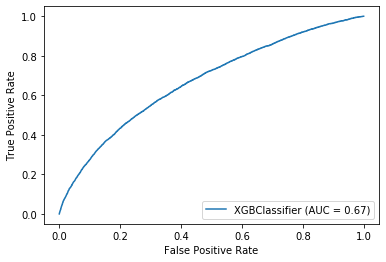

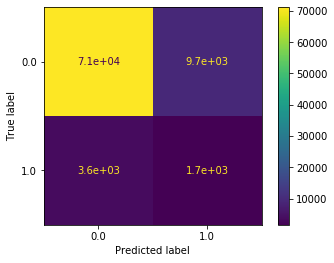

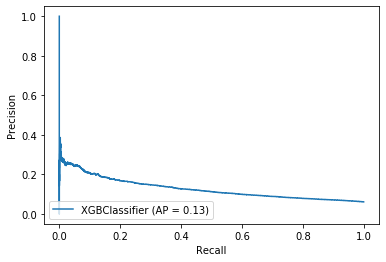

In [44]:
# plot
metrics.plot_roc_curve(model, X_test, y_test)
plt.show()
metrics.plot_confusion_matrix(model, X_test, y_test)
plt.show()
metrics.plot_precision_recall_curve(model, X_test, y_test)
plt.show()

In [0]:
# make predictions for submission test data
y_pred = model.predict_proba(X_S)
predictions = [value for value in y_pred[:, 1]]
submission_df['prob'] = predictions

In [0]:
submission_df = submission_df.loc[:, ['user_id', 'merchant_id', 'prob']]
submission_df.to_csv('result_submission.csv', index=False)
files.download('result_submission.csv')